In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# ตั้งค่าอุปกรณ์
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# โหลดไฟล์จาก "Merged Files"
base_folder = "Merged Files"
image_paths = [os.path.join(base_folder, f) for f in os.listdir(base_folder) if f.endswith((".png", ".jpg", ".jpeg"))]

# ตั้งค่า transform
data_transform = transforms.Compose([
    transforms.Resize((400, 400)),  # ปรับขนาดรูปภาพ
    transforms.ToTensor()
])

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [7]:
# สร้างโมเดลและ optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# ฝึกโมเดล
num_epochs = 10
for epoch in range(num_epochs):
    for img_name in os.listdir(base_folder):
        img_path = os.path.join(base_folder, img_name)
        
        image = Image.open(img_path).convert("RGB")
        image = data_transform(image).unsqueeze(0).to(device)
        
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, image)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# ดึงฟีเจอร์จาก encoder และบันทึกค่า hidden layer
model.eval()
features_vector = []
visual_samples = []
with torch.no_grad():
    for img_name in os.listdir(base_folder):
        img_path = os.path.join(base_folder, img_name)
        
        image = Image.open(img_path).convert("RGB")
        image = data_transform(image).unsqueeze(0).to(device)
        
        with torch.inference_mode():
            encoded, decoded = model(image)
            feature = encoded.view(-1).cpu().numpy()
        
        features_vector.append(feature)
        visual_samples.append((image.cpu().squeeze().permute(1, 2, 0).numpy(), encoded.cpu().squeeze().numpy()))

features_array = np.array(features_vector)  # แปลงเป็น array สำหรับ clustering
print("Extracted feature shape:", features_array.shape)


Epoch [1/10], Loss: 0.0035
Epoch [2/10], Loss: 0.0054
Epoch [3/10], Loss: 0.0023
Epoch [4/10], Loss: 0.0015
Epoch [5/10], Loss: 0.0010
Epoch [6/10], Loss: 0.0009
Epoch [7/10], Loss: 0.0012
Epoch [8/10], Loss: 0.0010
Epoch [9/10], Loss: 0.0007
Epoch [10/10], Loss: 0.0010
Extracted feature shape: (1115, 640000)


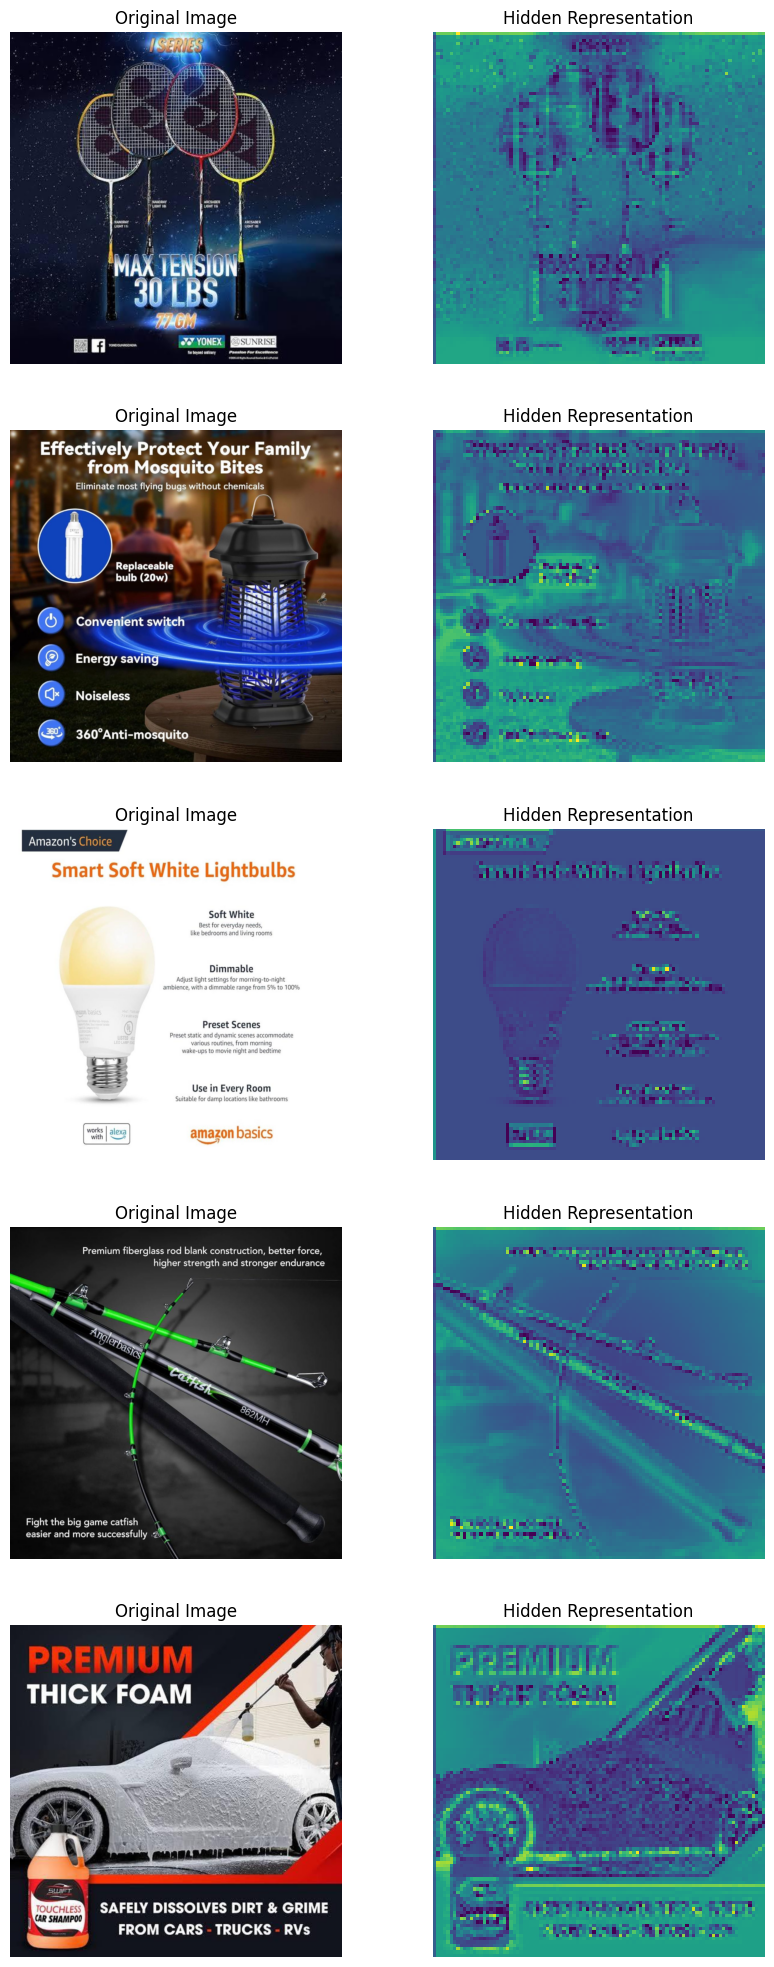

In [9]:
# Visualize hidden layers
num_visualizations = min(5, len(visual_samples))
fig, axes = plt.subplots(num_visualizations, 2, figsize=(10, 5 * num_visualizations))
for i, (orig, hidden) in enumerate(visual_samples[:num_visualizations]):
    axes[i, 0].imshow(orig)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(hidden[0], cmap="viridis")  # แสดงเฉพาะ channel แรกของ hidden
    axes[i, 1].set_title("Hidden Representation")
    axes[i, 1].axis("off")

plt.show()

In [10]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [11]:
kmean = KMeans(n_clusters=3, random_state=42)
kmean.fit(features_array)

c:\Users\BM MONEY\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

In [12]:
label = kmean.labels_

pca = PCA(n_components=2)
feature_pca = pca.fit_transform(features_array)

print(f'score: {silhouette_score(feature_pca, label)}')

score: 0.38375478982925415


In [13]:
import matplotlib.pyplot as plt

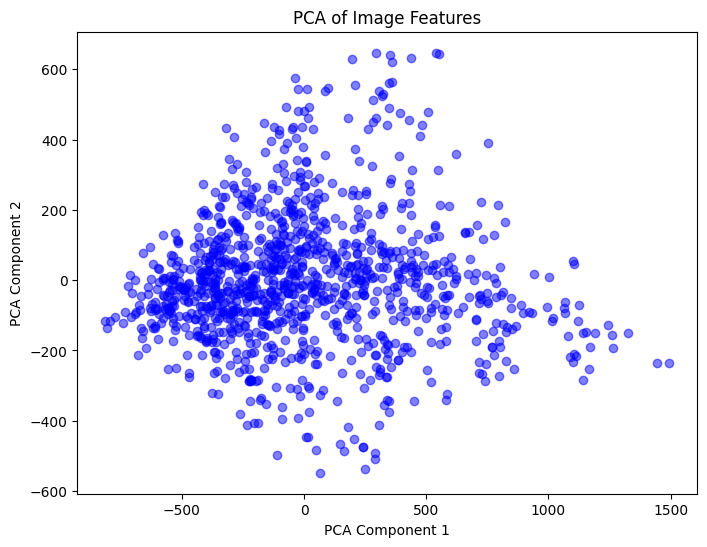

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(feature_pca[:, 0], feature_pca[:, 1], c='blue', marker='o', alpha=0.5)
plt.title("PCA of Image Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

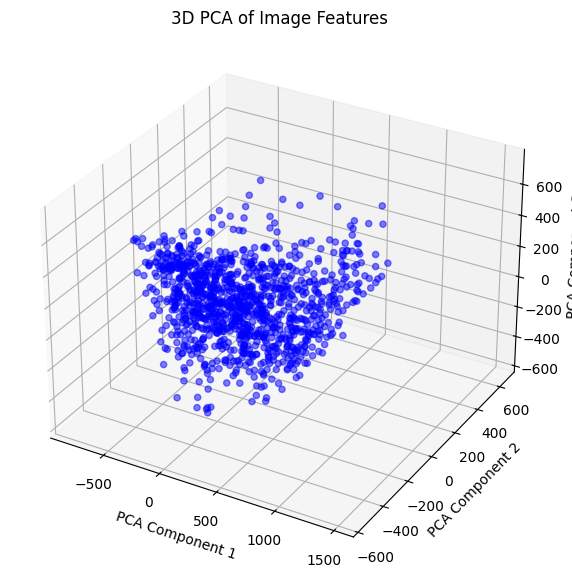

In [15]:
n_components = 3
pca = PCA(n_components=n_components)
features_pca = pca.fit_transform(features_array)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c='blue', marker='o', alpha=0.5)
ax.set_title("3D PCA of Image Features")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
plt.show()

c:\Users\BM MONEY\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\BM MONEY\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


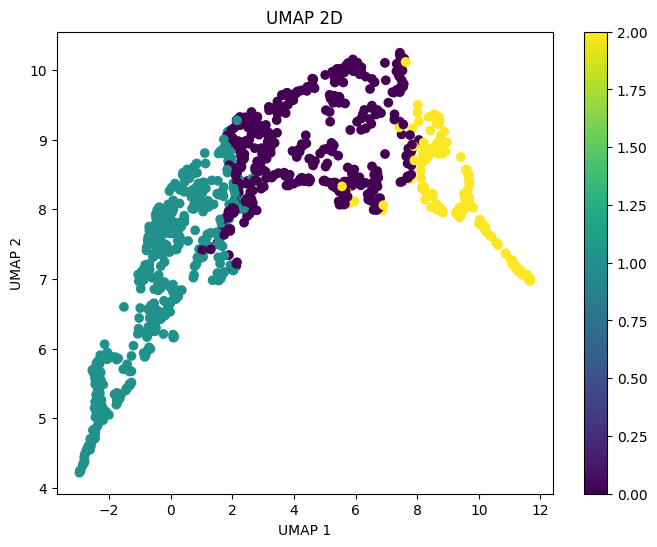

In [16]:
import umap

# ลดมิติด้วย UMAP
umap_model = umap.UMAP(n_components=300, random_state=42)
features_umap_2d = umap_model.fit_transform(features_pca)

# Plot 2D UMAP
plt.figure(figsize=(8, 6))
plt.scatter(features_umap_2d[:, 0], features_umap_2d[:, 1], c=label, cmap='viridis')
plt.title('UMAP 2D')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

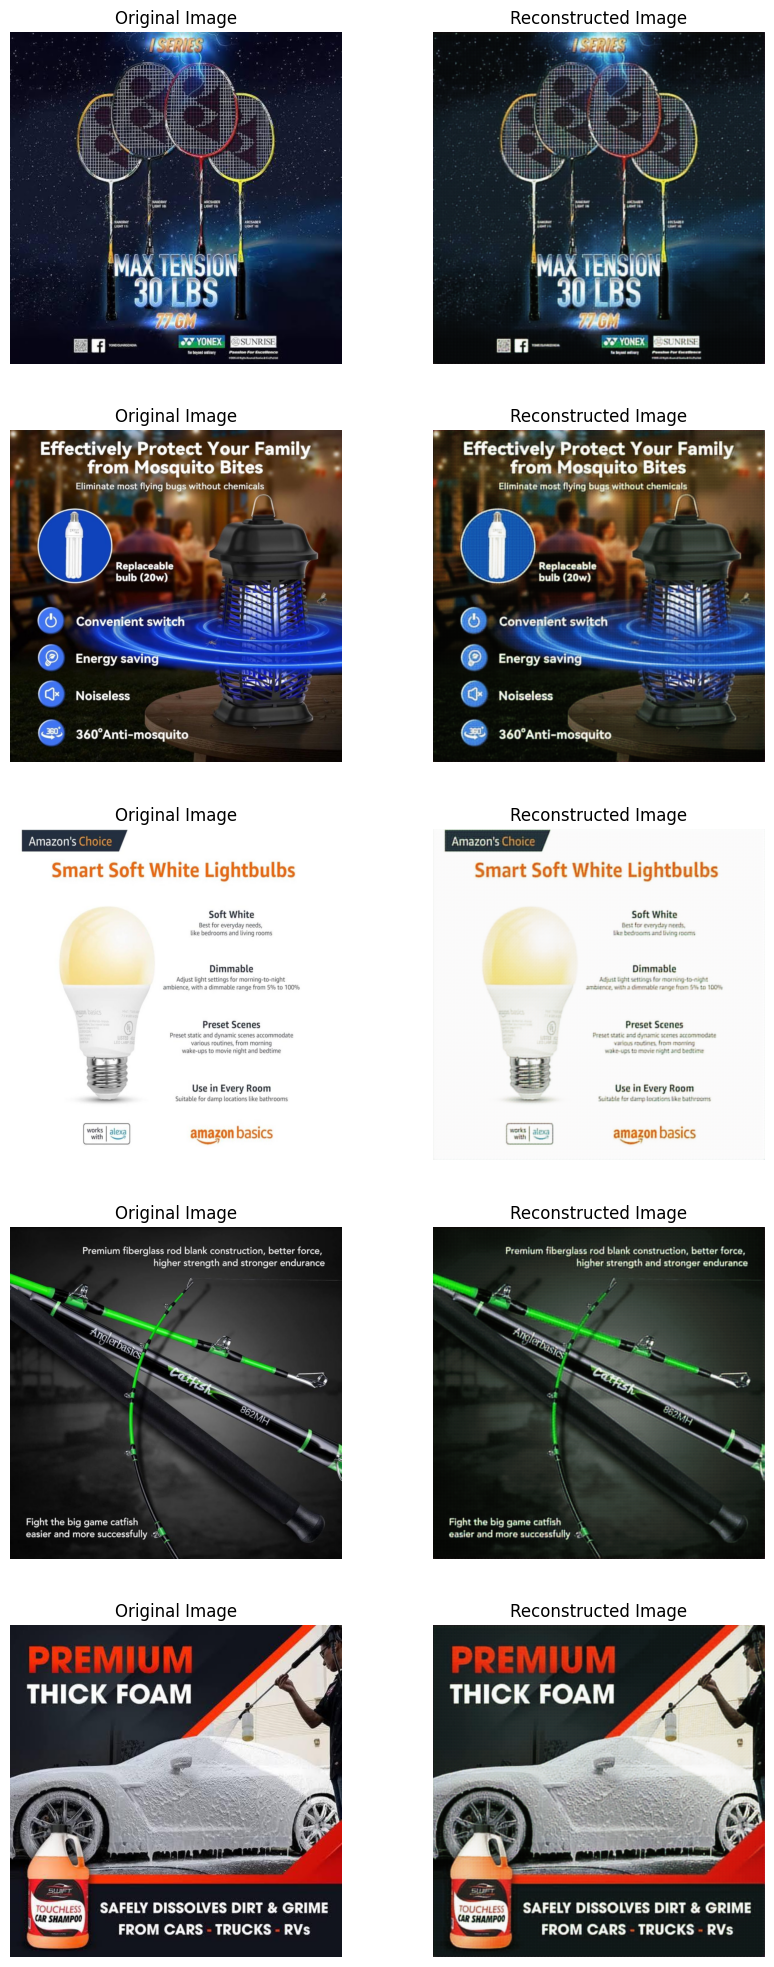

In [17]:
# ใช้ decoder สร้างภาพจาก encoded features
model.eval()
reconstructed_images = []
with torch.no_grad():
    for img_name in os.listdir(base_folder):
        img_path = os.path.join(base_folder, img_name)
        
        image = Image.open(img_path).convert("RGB")
        image = data_transform(image).unsqueeze(0).to(device)
        
        encoded, decoded = model(image)
        
        # เก็บภาพที่สร้างขึ้น (reconstructed)
        reconstructed_images.append(decoded.cpu().squeeze().numpy())

# Visualize original vs reconstructed images
fig, axes = plt.subplots(num_visualizations, 2, figsize=(10, 5 * num_visualizations))
for i, (orig, reconstructed) in enumerate(zip(visual_samples[:num_visualizations], reconstructed_images[:num_visualizations])):
    axes[i, 0].imshow(orig[0])  # Original image
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(reconstructed.transpose(1, 2, 0))  # Reconstructed image
    axes[i, 1].set_title("Reconstructed Image")
    axes[i, 1].axis("off")

plt.show()